# (1) Compute $k_i$

$$ k=\sum_{i=0}^{P} k_i \Phi_i(\xi)$$

$k_i$ are deterministic coefficients. We use the Galerkin projection to compute them:
$$ k_i=\frac{<k\Phi_i(\xi)>}{<\Phi_i^2(\xi)>}=\frac{1}{<\Phi_i^2(\xi)>}\int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi}
}k\Phi_i(\xi)e^{-\frac{\xi^2}{2}}\ d\xi$$

<font color = red> To be more general </font>
    
It is kind of meaningless becuase we don't know what $k$ is. We are gonna do something called an inverse sample transform, the reason why we can do that is because $k$ and $\xi$ are fully dependent

<font color = red> Numerator: </font> Using the CDF of both random variables, transform them to the same **uniform** random variables supported on $[0,1]$
$$u=G(\xi)=F(k)$$
$$k=F^{-1}(u)=h(u)$$
$$\xi=G^{-1}(u)=l(u)$$
Using this transform, the integral is transformed:
$$\int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi}}k\Phi_i(\xi)e^{-\frac{\xi^2}{2}}\ d\xi \Longrightarrow \int_0^1 h(u)\Phi_i(l(u))\ du$$

<font color = red> To be more general </font>

For the inner product term, three options:
- use the closed form representation from the orthogonality condition: $<\Phi_i^2(\xi)>=i!$ <font color = red> Here since the weight function is the real pdf of $\xi$, but weighting function in the package is just $e^{-\xi^2/2}$ </font>
- Choose a scaling of $\xi$ such that the orthogonality condition is just the Kronecker delta:
- Just compute the integral

<font color = red> Denominator: </font> Option 2 is best, but tedious. So let's go with option three using Gaussian-Hermite quadrature
$$ \int_{-\infty}^{\infty} f(x)e^{-\frac{x^2}{2}}\approx\sum_{i=0}^{N}w_i f(x_i)$$


In [1]:
import numpy as np
import numpy.polynomial.hermite_e as H
from scipy.stats import norm
import scipy.integrate as integrate
import scipy.integrate.quadrature as G_qua
from matplotlib import pyplot as plt

%matplotlib inline

The reason why it uses hermite_2 is because they are probabilists' Hermite polynomials, usually use notation $H_{e_0}, H_{e_1},\ldots$

In [158]:
H.hermeval(2, [0,1,1])

5.0

In [159]:
def Herm(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner_product(h1, h2):
    return lambda x: H.hermeval(x, H.hermemul(h1, h2))  


def trapezoid_int(f, a, b, n=100):
    P = [a + i*(b-a)/n for i in range(0, n+1)]
    F = [1/2*np.abs(P[i+1] - P[i])*(f(P[i+1]) + f(P[i])) for i in range(0, n)]  
    return sum(F)

def unif_icdf(params):
    a = params[0]
    b = params[1]
    return lambda u: u*(b-a)+a

def expo_icdf(params):
    return lambda u:-np.log(1-u)

def norm_icdf(params):                          #k=h(u)
    return lambda u:norm.ppf(u, loc=0, scale=1)

def factorial(n):
    k=1
    if n==0:
        k=1
    else:
        for i in range(1,n+1):
            k=k*i
    return k

# def h_phi_l(h):
#     return lambda x: h(x)*H.hermeval(norm.ppf(x,loc=0,scale=1),Herm(i))

In [160]:
def approximate_rv_coeffs(P,h):
    #P is the number of Hermite-Chaos
    #h is the inverse pdf of k
    #initialize lists for output to make syntax more canonical with the math
    ki=[0]*P
    
    #Set up Gauss-Hermite quadrature
    m=P**2
    x, w=H.hermegauss(m)        #x is point, w is the corresponding weight
    
    #Compute the coefficients, and also build out k in the same pass
    for i in range(0, P):
        #compute the inner product with Gaussian-Hermite quadrature, denominator
        ip=sum([inner_product(Herm(i), Herm(i))(x[idx]) * w[idx] for idx in range(m)])         
        #compute the integral, numerator
        integrand=lambda u:h(u)*H.hermeval(norm.ppf(u, loc=0, scale=1), Herm(i))     #norm.ppf, since expansion of \xi
        #ki[i]=np.sqrt(2*np.pi)/G_qua(h_phi_l(h), 0, 1)
        ki[i]=trapezoid_int(integrand, 0.001, 1-0.001, 1000)/factorial(i)
    return ki     #ki is the coefficient

In [161]:
def generate_rv(ki, S):
    #different P will give different ki
    #build out k termwise
    k = [0]*len(S)
    for i in range(len(ki)):
        k=np.add(k, ki[i]*H.hermeval(S, Herm(i)))
    return k

In [162]:
#Generate a bunch of Gaussian random variables to use
N=5000
S=np.random.normal(loc=0, scale=1, size=N)

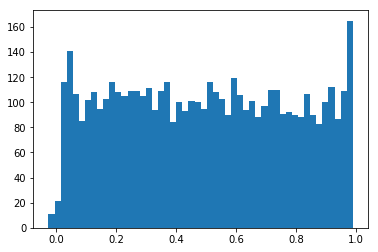

In [163]:
h = unif_icdf([0,1])                          #index k follows uniform distr
ki_uniform = approximate_rv_coeffs(10, h)     #change the order
k = generate_rv(ki_uniform, S)
out = plt.hist(k, bins=50)

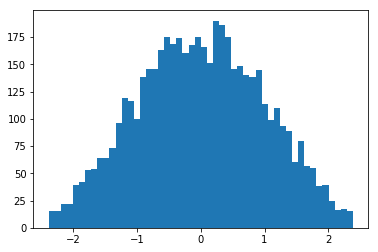

In [54]:
h = norm_icdf([])                          #index k follows norm distr
ki_norm = approximate_rv_coeffs(5, h)     #change the order
k = generate_rv(ki_norm, S)
out = plt.hist(k, bins=50)

In [55]:
ki_norm

[4.770489558936219e-18,
 0.9774860948298655,
 2.8796409701214993e-16,
 -0.03233346505595982,
 1.214306433183764e-17]

-0.0133265865433016

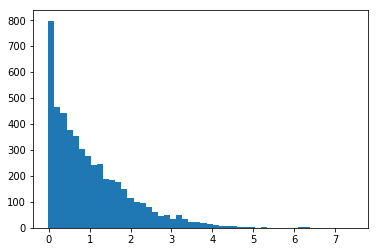

In [45]:
h = expo_icdf([])                          #index k follows expo distr
ki_expo = approximate_rv_coeffs(3, h)     #change the order
k = generate_rv(ki_expo, S)
out = plt.hist(k, bins=50)
k.min()

# (2) Compute $y_i$

In [26]:
def approx_inner2(P,i,j):
    #P is the number of Hermite-Chaos

    #Set up Gauss-Hermite quadrature
    m=P**2
    x, w=H.hermegauss(m)        #x is point, w is the corresponding weight
    inner=sum([inner_product(Herm(i), Herm(j))(x[idx]) * w[idx] for idx in range(m)])         
    
    return np.sqrt(2*np.pi)*inner

-----
Doesn't work

In [23]:
def approx_inner3(P,i,j,l):
    #P is the number of Hermite-Chaos

    #Set up Gauss-Hermite quadrature
    m=P**2
    x, w=H.hermegauss(m)        #x is point, w is the corresponding weight
    inner=sum([inner_product(inner_product(Herm(i), Herm(j)),Herm(l))(x[idx]) * w[idx] for idx in range(m)])         
    
    return np.sqrt(2*np.pi)*inner

----

In [31]:
def inner3_product(i,j,l):
    return lambda x: H.hermeval(x, H.hermemul(H.hermemul(Herm(i),Herm(j)),Herm(l))) 

In [93]:
def approx_inner3(P,i,j,l):
    #P is the number of Hermite-Chaos

    #Set up Gauss-Hermite quadrature
    m=P**2
    x, w=H.hermegauss(m)        #x is point, w is the corresponding weight
    inner=sum([inner3_product(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
#     return np.sqrt(2*np.pi)*inner
    return inner/np.sqrt(2*np.pi)

In [94]:
approx_inner3(3,1,1,1)

4.602162686824381e-17

In [95]:
def ode_system(y, t):
    y0, y1, y2 = y
    dydt = [(-approx_inner3(3,1,0,0)*y0 - approx_inner3(3,1,1,0)*y1 - approx_inner3(3,1,2,0)*y2),
            (-approx_inner3(3,1,0,1)*y0 - approx_inner3(3,1,1,1)*y1 - approx_inner3(3,1,2,1)*y2),
            (-approx_inner3(3,1,0,2)*y0 - approx_inner3(3,1,1,2)*y1 - approx_inner3(3,1,2,2)*y2)/2]
    return dydt

In [ ]:
def ode_system(y, t):
    y0, y1, y2 = y
    dy0dt = (-inner3(3,1,0,0)*y0 - inner3(3,1,1,0)*y1 - inner3(3,1,2,0)*y2)
    dy1dt = (-inner3(3,1,0,1)*y0 - inner3(3,1,1,1)*y1 - inner3(3,1,2,1)*y2)
    dy2dt = (-inner3(3,1,0,2)*y0 - inner3(3,1,1,2)*y1 - inner3(3,1,2,2)*y2)/2
    return dy0dt, dy1dt, dy2dt

----

In [96]:
from scipy.integrate import odeint

In [97]:
sol = odeint(ode_system, [1.0, 0.0, 0.0], np.linspace(0,1,101))

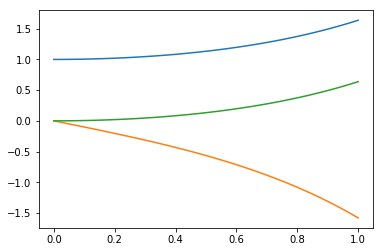

In [99]:
plt.figure()
plt.plot(np.linspace(0,1,101),sol[:,0])
plt.plot(np.linspace(0,1,101),sol[:,1])
plt.plot(np.linspace(0,1,101),sol[:,2])

In [2]:
def inner2_product(h1, h2):
    return lambda x: H.hermeval(x, H.hermemul(h1, h2))     

def inner3_product(h1,h2,h3):
    return lambda x: H.hermeval(x, H.hermemul(H.hermemul(h1,h2),h3)) 

def integ1_func(h1,h2):
    return lambda x:inner2_product(h1,h2)(x)*(norm.pdf(x))

---

In [ ]:
def exact_mean(t):
    f=np.exp(t**2/2)
    return f

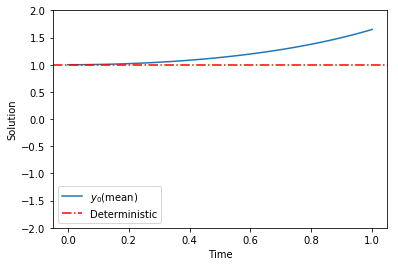

In [3]:
t=np.linspace(0,1,100)
plt.ylim([-2,2])
plt.plot(t, exact_mean(t),label="$y_0$(mean)")

plt.axhline(y=1.0, color='r', linestyle='-.',label='Deterministic')

#plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel("Solution")
plt.xlabel("Time")
plt.legend(loc=3)